In [1]:
import torch
from torch.autograd import Variable

## Get a state of the double integrator

<p align="center">
  <img src="double_integrator_brick.svg" width="350"/>
</p>

In [2]:
### initial state and parameters

## parameters
width  = 10.0 # width of brick in pixels
height = 5.0
t_f = 1000     # number of time steps

## state
x    = 30.0 # position to right in pixels
xdot = 0.0  # 

state_initial = torch.FloatTensor([x, xdot])
state_initial = Variable(state_initial, requires_grad=False)
print state_initial

Variable containing:
 30
  0
[torch.FloatTensor of size 2]



## Differentiably render double integrator

- Convert state of double integrator to an AABB list of corners in img
- Find all pixels inside AABB

In [3]:
import numpy as np
pi = np.pi

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50

def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]

def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch_det(A-B, A-P))/(B-A).norm()

def inside_aabb(aabb_corners, P):
    # check x conditions
    if (P[0] < aabb_corners[0][0]).all() or (P[0] > aabb_corners[3][0]).all():
        return False
    
    # check y conditions
    if (P[1] < aabb_corners[0][1]).all() or (P[1] > aabb_corners[3][1]).all():
        return False
    
    return True

def distance_to_aabb(aabb_corners, P):
    # if inside aabb, return 0
    distance_to_left   = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_top    = distance_pytorch(aabb_corners[1], aabb_corners[3], P)
    distance_to_right  = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_bottom = distance_pytorch(aabb_corners[0], aabb_corners[1], P) 

0.000494003295898  seconds for state to img


<IPython.core.display.Javascript object>


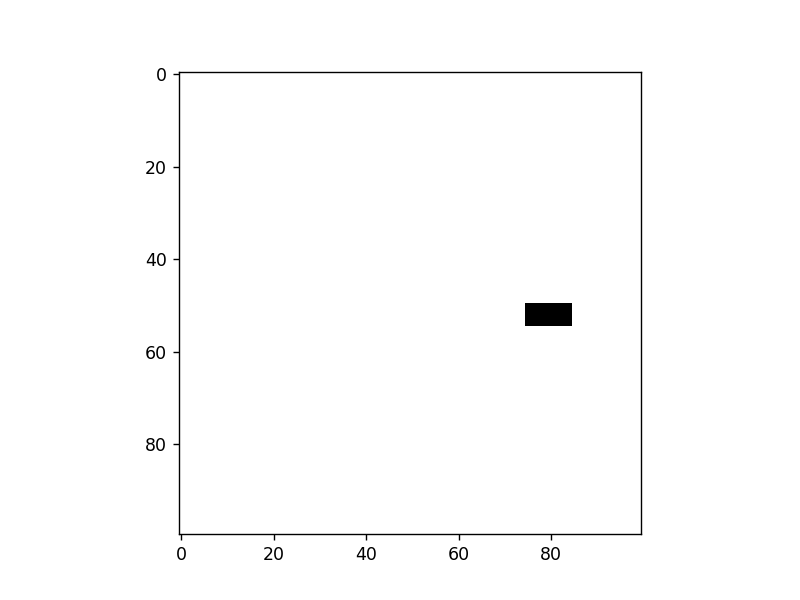

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)

def vectorized_inside_aabb(aabb_corners):
    img = Variable(torch.ones((100,100)), requires_grad=False)
    img[0:int(aabb_corners[0][0]),:] = 0.0
    img[int(aabb_corners[3][0]):,:] = 0.0
    img[:,0:int(aabb_corners[0][1])] = 0.0
    img[:,int(aabb_corners[3][1]):] = 0.0
    return img
    
def double_integrator_state_to_img(state):
    center = Variable(torch.zeros(2), requires_grad = False)
    center[1] = state[0]
    center_in_img = convert_world_to_img_coordinates(center)

    lower_left  = center + Variable(torch.FloatTensor([0,      -width/2]), requires_grad=False)
    upper_left  = center + Variable(torch.FloatTensor([height, -width/2]), requires_grad=False)
    lower_right = center + Variable(torch.FloatTensor([0,       width/2]), requires_grad=False)
    upper_right = center + Variable(torch.FloatTensor([height,  width/2]), requires_grad=False)

    corners = [lower_left, upper_left, lower_right, upper_right]
    corners_in_img = [convert_world_to_img_coordinates(x) for x in corners]
    
    return vectorized_inside_aabb(corners_in_img)

import time; start = time.time()
img = double_integrator_state_to_img(state_initial)
print time.time() - start, " seconds for state to img"
plt.imshow(img.data, cmap=plt.get_cmap('gray_r'))
plt.show()

## State feedback: perform state feedback with just PD

In [5]:
def pd_origin_controller(state):
    x_desired = 0
    xdot_desired = 0
    diff_pos = (x_desired    - state[0])
    diff_vel = (xdot_desired - state[1])
    u = 1000*diff_pos + 100*diff_vel
    if (u > 500).all():
        u = u*0 + 500  # this trick mantains u as a Variable
    if (u < -500).all():
        u = u*0 -500
    return u

def double_integrator_next_state(state, u):
    deriv = Variable(torch.zeros(2), requires_grad = False)
    deriv[0] = state[1]
    deriv[1] = u
    dt = .01
    next_state = state + deriv*dt
    return next_state

state_tape = []
state_tape.append(state_initial)

for i in range(t_f):
    u = pd_origin_controller(state_tape[-1])
    next_state = double_integrator_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)

1001


## Convert states to imgs

In [6]:
img_tape = []

for i in state_tape:
    img_tape.append(double_integrator_state_to_img(i))
    
print len(img_tape)

1001


## Visualize

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

def get_animation(img_tape):
    fig = plt.figure()
    first_img = img_tape[0].data
    im = plt.imshow(first_img, cmap='gist_gray_r')

    def init():
        im.set_data(first_img)

    def animate(i):
        im.set_data(img_tape[i].data)
        return im

    animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=20, blit=True)
    plt.close(fig)
    return animate
    
#ani = get_animation(img_tape)
#HTML(ani.to_html5_video())

In [9]:
# plotting etc examples for reference
# https://gist.github.com/AndrewWalker/2687988
# https://matplotlib.org/examples/animation/double_pendulum_animated.html

## Optimization over output feedback policies

We would like to directly optimize an output feedback policy $\pi$, i.e.

\begin{align*}
        \min_{x(.), u(.), \pi} \ \ \ & \int_{t_0}^{t_f} g(x(t),u(t)) dt\\
        s.t. \ \ \  & \forall t, \ \ \dot{x}(t) = f(x(t),u(t)), \\
        & x(t_0) = x_0, \\
        & u = \pi(y(x))
\end{align*}

Where $y(x)$ is the renderer.

We would like to solve this optimization from many initial samples $x_{0,i}$ and simultaneously optimize the feedback policy given a particular form, for example linear feedback $u = Ky(x)$.



## Unconstrained "shooting" method optimization for linear feedback from one initial condition

For one initial condition $x_0$, linear feedback $u = Ky(x)$, and one choice of time horizon $t_f$, we can formulate this is a shooting method type optimization as follows:

\begin{align*}
        \min_{K} \ \ \ & \int_{t_0}^{t_f} g(x(t),u(t)) dt\\
        s.t. \ \ \  & \forall t, \ \ \dot{x}(t) = f(x(t),u(t)), \\
        & x(t_0) = x_0, \\
        & u = Ky(x)
\end{align*}

With our decision variables being only K, we can solve this from an initial guess and backpropagation.  This could work for any differentiable feedback policy $\pi$ but we can start with just linear feedback.

We'll use the simplest quadratic cost:

$$g(x(t), u(t)) = x^Tx + u^Tu $$

In [11]:
### output feedback policy

## initial policy parameters
flat_img = img.view(-1,1)
K = Variable((torch.rand(flat_img.shape)-0.5)*.01, requires_grad=True)

## policy
def output_feedback_policy(flat_img, K):
    return torch.t(K).mm(flat_img)

state_tape = []
state_tape.append(state_initial)
img_tape = []
img_tape.append(double_integrator_state_to_img(state_initial))
u_tape = []
    
### simulate initial policy
for i in range(t_f):
    y = img_tape[-1]
    flat_img = y.view(-1,1)
    u = output_feedback_policy(flat_img, K)
    next_state = double_integrator_next_state(state_tape[-1],u[0][0])
    state_tape.append(next_state)
    next_y     = double_integrator_state_to_img(next_state) 
    img_tape.append(next_y)
    u_tape.append(u)
    
print len(state_tape)
print len(img_tape)
print len(u_tape)

## after the fact, go get the running cost
cost = 0
for i in state_tape[1:]:
    cost += i.pow(2).sum()
    
for i in u_tape:
    cost += i.pow(2).sum()
    
print cost

1001
1001
1000
Variable containing:
1.00000e+05 *
  8.8437
[torch.FloatTensor of size 1]



<IPython.core.display.Javascript object>


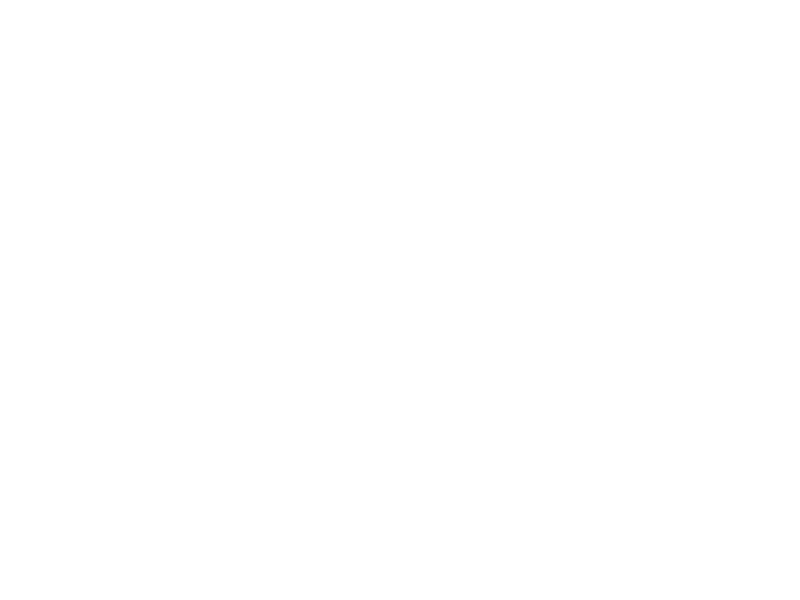

In [12]:
## visualize initial policy

ani = get_animation(img_tape)
HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>


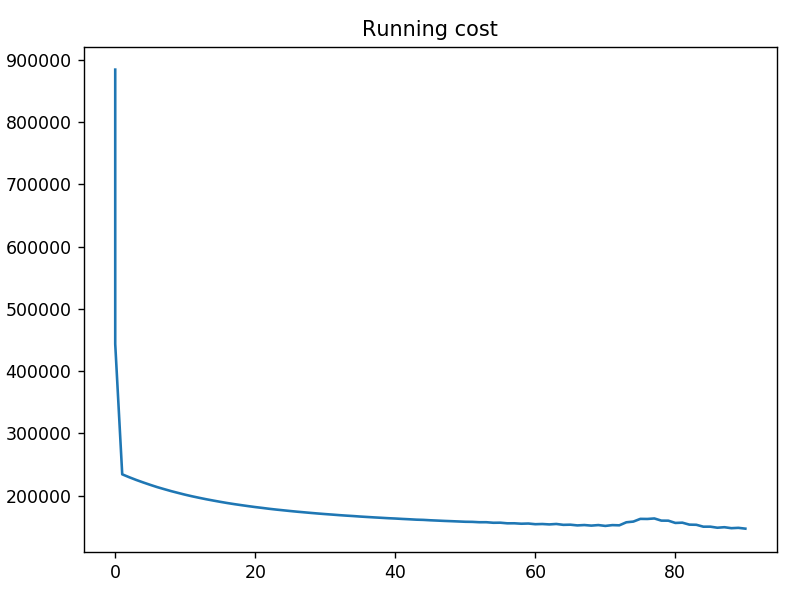

In [13]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [15]:
## optimize

num_iterations = 100
step_rate = 1e-7

# K has already been initialized above, and initial policy visualized
print K

for cost_iteration in range(num_iterations):
    print "iter", cost_iteration
    
    state_tape = []
    
    state_tape.append(state_initial)
    img_tape = []
    img_tape.append(double_integrator_state_to_img(state_initial))
    u_tape = []
    
    ### simulate policy
    for j in range(t_f):
        y = img_tape[-1]
        flat_img = y.view(-1,1)
        u = output_feedback_policy(flat_img, K)
        next_state = double_integrator_next_state(state_tape[-1],u[0][0])
        state_tape.append(next_state)
        next_y     = double_integrator_state_to_img(next_state) 
        img_tape.append(next_y)
        u_tape.append(u)


    ## after the fact, go get the running cost
    cost = 0
    for i in state_tape[1:]:
        cost += i[0].pow(2).sum()

    #for i in u_tape:
    #    cost += i.pow(2).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
    
print K

Variable containing:
-4.9489e-03
-2.0334e-03
 4.8682e-03
     ⋮      
 1.4717e-03
 3.1662e-03
 3.5934e-03
[torch.FloatTensor of size 10000x1]

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 57
iter 58
iter 59
iter 60
iter 61
iter 62
iter 63
iter 64
iter 65
iter 66
iter 67
iter 68
iter 69
iter 70
iter 71
iter 72
iter 73
iter 74
iter 75
iter 76
iter 77
iter 78
iter 79
iter 80
iter 81
iter 82
iter 83
iter 84
iter 85
iter 86
iter 87
iter 88
iter 89
iter 90
iter 91
iter 92
iter 93
iter 94
iter 95
iter 96
iter 97
iter 98
iter 99
Variable containing:
-4.9489e-03
-2.0334e-03
 4.8682e-03
     ⋮    

<IPython.core.display.Javascript object>


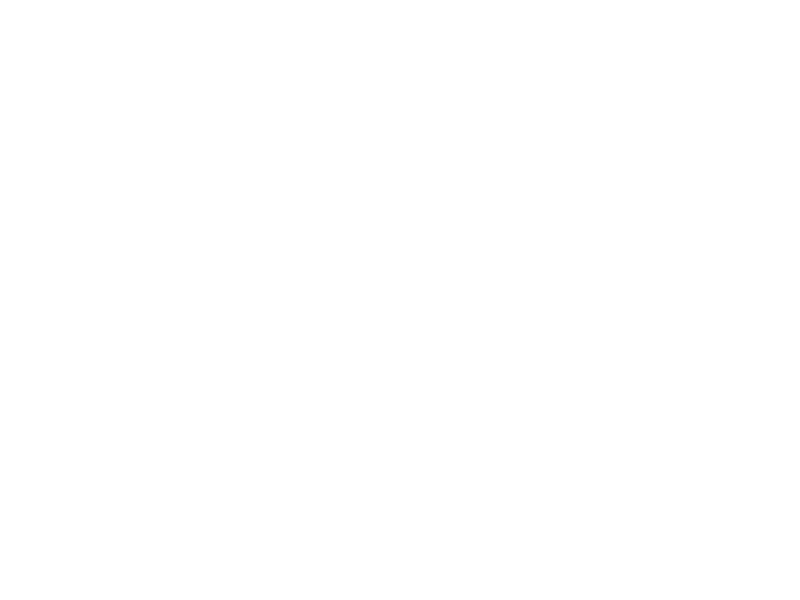

In [16]:
## visualize final policy

ani = get_animation(img_tape)
HTML(ani.to_html5_video())